In [61]:
%load_ext autoreload
%autoreload 2

import torch
import logging
import matplotlib.pyplot as plt
import experiments.base.multiclass_classification as exp
from experiments.base import mnist
from training.util import plot_losses, adam, sgd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [3]:
batch_size = 32
# LeNet with ReLu
layers = [
    ("conv", (1, 6, 5)),
    ("relu", ()),
    ("pool", 2),
    ("conv", (6, 16, 5)),
    ("relu", ()),
    ("pool", 2),
    ("flatten", ()),
    ("fc", (16 * 4 * 4, 120)),
    ("relu", ()),
    ("fc", (120, 84)),
    ("relu", ()),
    ("fc", (84, 10)),
    ("logsoftmax", ())
]

In [4]:
torch.manual_seed(42)

trainloader = mnist.fashion_trainloader("/mnt/d/Uni/Bachelorarbeit/linux/data/", batch_size)
testloader = mnist.fashion_testloader("/mnt/d/Uni/Bachelorarbeit/linux/data/", batch_size)
corrupted_testloader = mnist.corrupted_fashion_testloader("/mnt/d/Uni/Bachelorarbeit/linux/data/", batch_size)

In [139]:
from training.vogn import VOGNModule

torch.manual_seed(42)
layers = [
    ("conv", (1, 6, 5)),
    ("relu", ()),
    ("pool", 2),
    ("conv", (6, 16, 5)),
    ("relu", ()),
    ("pool", 2),
    ("flatten", ()),
    ("fc", (16 * 4 * 4, 120)),
    ("relu", ()),
    ("fc", (120, 84)),
    ("relu", ()),
    ("fc", (84, 10)),
    ("logsoftmax", ())
]
vogn = VOGNModule(layers)
vogn.train_model(20, torch.nn.NLLLoss(), {"lr": 0.001, "prior_prec": 10, "damping": 1e-3, "betas": (0.9, 0.999), "sample": True}, trainloader, batch_size, device, report_every_epochs=1, mc_samples=5)


Epoch 0: loss 1.2751320600509644
Epoch 1: loss 0.6830992102622986
Epoch 2: loss 0.624006986618042
Epoch 3: loss 0.5861127376556396
Epoch 4: loss 0.565437912940979
Epoch 5: loss 0.5479065775871277
Epoch 6: loss 0.5372028946876526
Epoch 7: loss 0.5299845933914185
Epoch 8: loss 0.5194750428199768
Epoch 9: loss 0.5139337778091431
Epoch 10: loss 0.50716632604599
Epoch 11: loss 0.5013648867607117
Epoch 12: loss 0.49498656392097473
Epoch 13: loss 0.4903052747249603
Epoch 14: loss 0.4840734899044037
Epoch 15: loss 0.4801945686340332
Epoch 16: loss 0.4749296009540558
Epoch 17: loss 0.4740292429924011
Epoch 18: loss 0.46994709968566895
Epoch 19: loss 0.4664086699485779
Final loss 0.4664086699485779


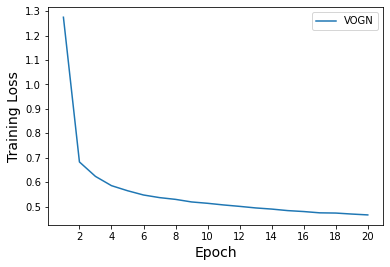

In [140]:
plot_losses("VOGN", vogn.all_losses(), plt.subplot())

In [141]:
acc, cal = exp.eval_model(vogn, 100, testloader, device)

 Accuracy: 0.8270000219345093
 ECE: 0.03078714856505394


/home/flo/VariationalBayesianDL/training/calibration.py:127: UserWarning: FixedFormatter should only be used together with FixedLocator
  count_ax.set_xticklabels(self.bin_counts)


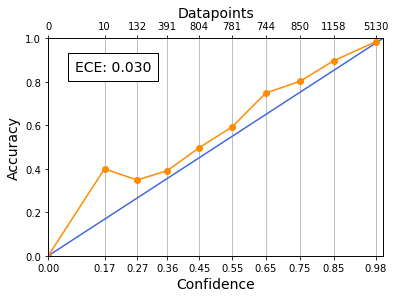

In [138]:
import matplotlib.pyplot as plt
cal.plot_reliability(plt.subplot())

In [146]:
from training.pp import MAP

torch.manual_seed(42)
pp = MAP(layers)
pp.train_model(5, torch.nn.NLLLoss(), sgd(0.1, weight_decay=1e-4), trainloader, batch_size, device, report_every_epochs=1)
#torch.save(pp.state_dict(), "trained_models/mnist/pp.tar")
#pp.load_state_dict(torch.load("trained_models/mnist/pp.tar"))
#pp.load_state_dict(torch.load("experiments/fmnist/results/MAP/log/rep_00map.tar"))
#pp.to(device)

Epoch 0: loss 0.6100773811340332
Epoch 1: loss 0.37415653467178345
Epoch 2: loss 0.32804080843925476
Epoch 3: loss 0.29935726523399353
Epoch 4: loss 0.27993765473365784
Final loss 0.27993765473365784


In [152]:
pp_acc, pp_avg_ll, pp_avg_ll, pp_cal = exp.eval_model(pp, 100, testloader, device)

 Accuracy: 0.8880000114440918
 Avg Log Likelihood: -0.32003918290138245
 Avg Likelihood: 0.8537865281105042
 ECE: 0.022783233043551444


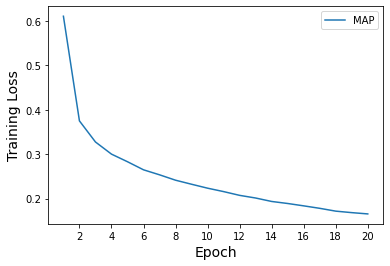

In [96]:
plot_losses("MAP", pp.all_losses(), plt.subplot())

/home/flo/VariationalBayesianDL/training/calibration.py:127: UserWarning: FixedFormatter should only be used together with FixedLocator
  count_ax.set_xticklabels(self.bin_counts)


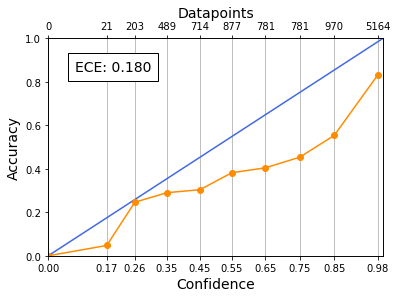

In [98]:
import matplotlib.pyplot as plt
pp_cal.plot_reliability(plt.subplot())

In [32]:
torch.manual_seed(42)
from training.swag import SwagModel
swag_config = {
    "update_every_batches": len(trainloader) // 8,
    "deviation_samples": 30,
    "start_epoch": 8
}
swag = SwagModel(layers, swag_config)
#swag.train_model(12, torch.nn.NLLLoss(), sgd(0.1), trainloader, batch_size, device, report_every_epochs=1)
#torch.save(swag.state_dict(), "trained_models/mnist/swag.tar")
swag.load_state_dict(torch.load("trained_models/mnist/swag.tar"))
swag.to(device)

SwagModel(
  (model): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=256, out_features=120, bias=True)
    (8): ReLU()
    (9): Linear(in_features=120, out_features=84, bias=True)
    (10): ReLU()
    (11): Linear(in_features=84, out_features=10, bias=True)
    (12): LogSoftmax(dim=1)
  )
)

In [34]:
from training.ensemble import Ensemble

torch.manual_seed(42)
ensemble = Ensemble([PointPredictor(layers) for _ in range(5)])
ensemble.train_model(10, torch.nn.NLLLoss(), sgd(0.1), trainloader, batch_size, device)
torch.save(ensemble.state_dict(), "trained_models/mnist/ensemble.tar")
#ensemble.load_state_dict(torch.load("trained_models/mnist/ensemble.tar"))
#ensemble.to(device)

Training ensemble member 0
Epoch 0: loss 0.019129440188407898
Epoch 1: loss 0.01168946735560894
Epoch 2: loss 0.0101430369541049
Epoch 3: loss 0.00920447800308466
Epoch 4: loss 0.008566115982830524
Epoch 5: loss 0.008094082586467266
Epoch 6: loss 0.007716674357652664
Epoch 7: loss 0.007293311413377523
Epoch 8: loss 0.007014991249889135
Epoch 9: loss 0.006797648500651121
Final loss 0.006797648500651121
Training ensemble member 1
Epoch 0: loss 0.019484544172883034
Epoch 1: loss 0.01126466877758503
Epoch 2: loss 0.009957398287951946
Epoch 3: loss 0.009129923768341541
Epoch 4: loss 0.008526795543730259
Epoch 5: loss 0.008164551109075546
Epoch 6: loss 0.007699306588619947
Epoch 7: loss 0.007412070874124765
Epoch 8: loss 0.0071570128202438354
Epoch 9: loss 0.0069142538122832775
Final loss 0.0069142538122832775
Training ensemble member 2
Epoch 0: loss 0.01918148808181286
Epoch 1: loss 0.011193064972758293
Epoch 2: loss 0.009868397377431393
Epoch 3: loss 0.009047170169651508
Epoch 4: loss 0.00

In [122]:
torch.manual_seed(42)
layers = [
    ("conv", (1, 6, 5)),
    ("dropout", (0.2,)),
    ("relu", ()),
    ("pool", 2),
    ("conv", (6, 16, 5)),
    ("dropout", (0.2,)),
    ("relu", ()),
    ("pool", 2),
    ("flatten", ()),
    ("fc", (16 * 4 * 4, 120)),
    ("dropout", (0.2,)),
    ("relu", ()),
    ("fc", (120, 84)),
    ("dropout", (0.2,)),
    ("relu", ()),
    ("fc", (84, 10)),
    ("logsoftmax", ())
]
mc_dropout = MAP(layers)
mc_dropout.train_model(20, torch.nn.NLLLoss(), sgd(0.1, weight_decay=1e-4), trainloader, batch_size, device)
#torch.save(mc_dropout.state_dict(), "trained_models/mnist/mc_dropout.tar")
#mc_dropout.load_state_dict(torch.load("trained_models/mnist/mc_dropout.tar"))
#mc_dropout.to(device)

Epoch 0: loss 0.7220839858055115
Epoch 1: loss 0.4493975043296814
Epoch 2: loss 0.38700422644615173
Epoch 3: loss 0.35418030619621277
Epoch 4: loss 0.3354940414428711
Epoch 5: loss 0.3209177553653717
Epoch 6: loss 0.31007590889930725
Epoch 7: loss 0.30196645855903625
Epoch 8: loss 0.29211369156837463
Epoch 9: loss 0.2861540913581848
Epoch 10: loss 0.2818082273006439
Epoch 11: loss 0.2774829864501953
Epoch 12: loss 0.2733573615550995
Epoch 13: loss 0.2665083408355713
Epoch 14: loss 0.265163779258728
Epoch 15: loss 0.261074423789978
Epoch 16: loss 0.258986234664917
Epoch 17: loss 0.25749313831329346
Epoch 18: loss 0.2510659098625183
Epoch 19: loss 0.24953268468379974
Final loss 0.24953268468379974


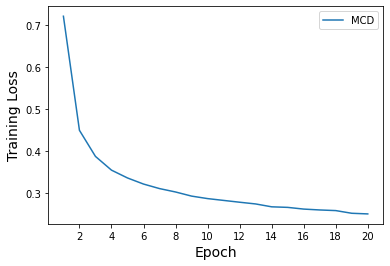

In [123]:
plot_losses("MCD", mc_dropout.all_losses(), plt.subplot())

In [124]:
mcd_acc, mcd_cal = exp.eval_model(pp, 100, testloader, device)

 Accuracy: 0.8974000215530396
 ECE: 0.03814297971725464


/home/flo/VariationalBayesianDL/training/calibration.py:127: UserWarning: FixedFormatter should only be used together with FixedLocator
  count_ax.set_xticklabels(self.bin_counts)


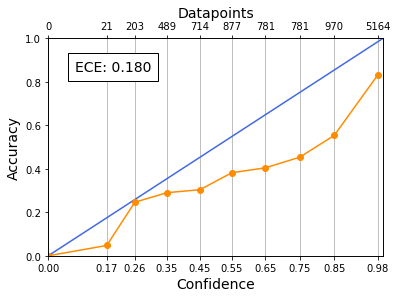

In [116]:
mcd_cal.plot_reliability(plt.subplot())

In [40]:
from training.bbb import GaussianPrior, BBBModel

torch.manual_seed(42)
bbb_prior = GaussianPrior(0, 1)
bbb = BBBModel(bbb_prior, "activations", layers)
#bbb.train_model(15, torch.nn.NLLLoss(reduction="mean"), sgd(0.1), trainloader, batch_size, device, kl_rescaling=0.01)
#torch.save(bbb.state_dict(), "trained_models/mnist/bbb.tar")
bbb.load_state_dict(torch.load("trained_models/mnist/bbb.tar"))
bbb.to(device)

Epoch 0: loss 0.020160101354122162
Epoch 1: loss 0.014413719065487385
Epoch 2: loss 0.012995382770895958
Epoch 3: loss 0.012178227305412292
Epoch 4: loss 0.011554375290870667
Epoch 5: loss 0.011050408706068993
Epoch 6: loss 0.010678076185286045
Epoch 7: loss 0.010341538116335869
Epoch 8: loss 0.010046809911727905
Epoch 9: loss 0.009717647917568684
Epoch 10: loss 0.009449685923755169
Epoch 11: loss 0.00913200806826353
Epoch 12: loss 0.008964103646576405
Epoch 13: loss 0.008768453262746334
Epoch 14: loss 0.008508812636137009
Final loss 0.008508812636137009


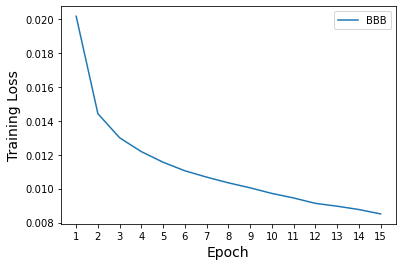

In [43]:
from training.util import plot_losses
import matplotlib.pyplot as plt
plot_losses("BBB", bbb.all_losses(), plt.subplot())

Epoch 0: loss 0.03884917125105858
Final loss 0.03884917125105858


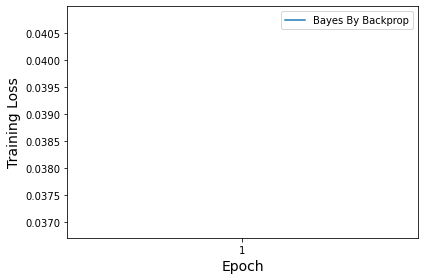

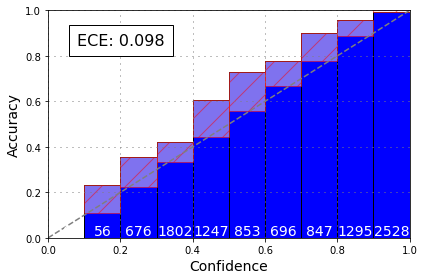

In [11]:
from training.bbb import GaussianPrior, BBBModel

bbb_prior = GaussianPrior(0, 1)
layers = [
    ("v_conv", (1, 6, 5, bbb_prior, {})),
    ("relu", ()),
    ("pool", 2),
    ("v_conv", (6, 16, 5, bbb_prior, {})),
    ("relu", ()),
    ("pool", 2),
    ("flatten", ()),
    ("v_fc", (16 * 4 * 4, 120, bbb_prior, {})),
    ("relu", ()),
    ("v_fc", (120, 84, bbb_prior, {})),
    ("relu", ()),
    ("v_fc", (84, 10, bbb_prior, {})),
    ("logsoftmax", ())
]

torch.manual_seed(42)
bbb = BBBModel(layers)
bbb.train_model(1, torch.nn.NLLLoss(reduction="mean"), sgd(0.01), trainloader, batch_size, device, mc_samples=2, kl_rescaling=0.1)
#torch.save(bbb.state_dict(), "trained_models/mnist/bbb.tar")
#bbb.load_state_dict(torch.load("trained_models/mnist/bbb.tar"))
#bbb.to(device)
exp.eval_model("Bayes By Backprop", bbb, 100, testloader, device, None, logging.getLogger())

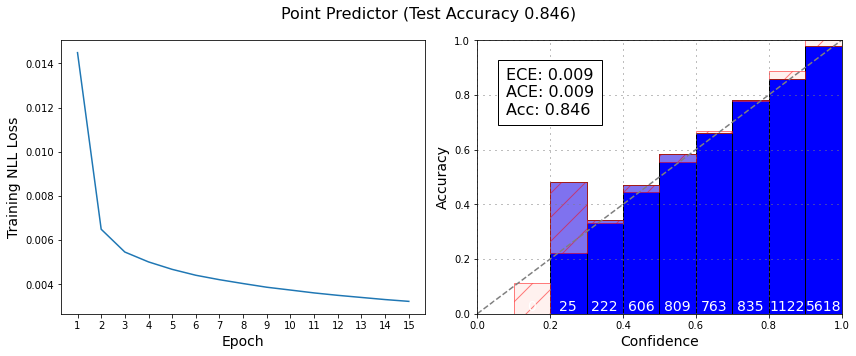

In [28]:
exp.eval_model("Point Predictor", pp.infer, pp.all_losses(), 1, testloader, device).savefig("figures/fmnist_pp_15e.png")

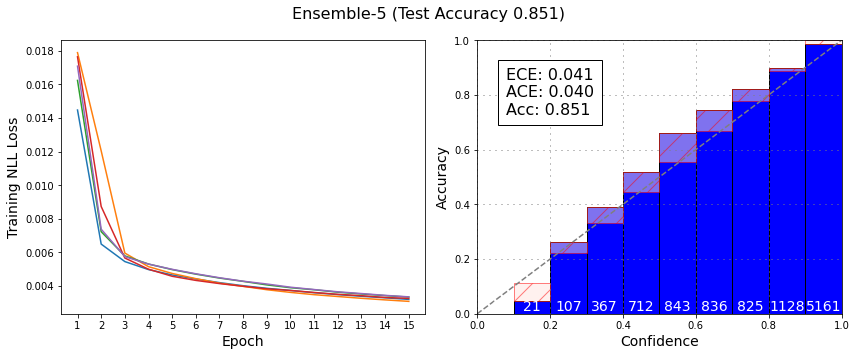

In [12]:
exp.eval_model("Ensemble-5", ensemble.infer, ensemble.all_losses(), 5, testloader, device).savefig("figures/fmnist_ensemble5_15e.png")

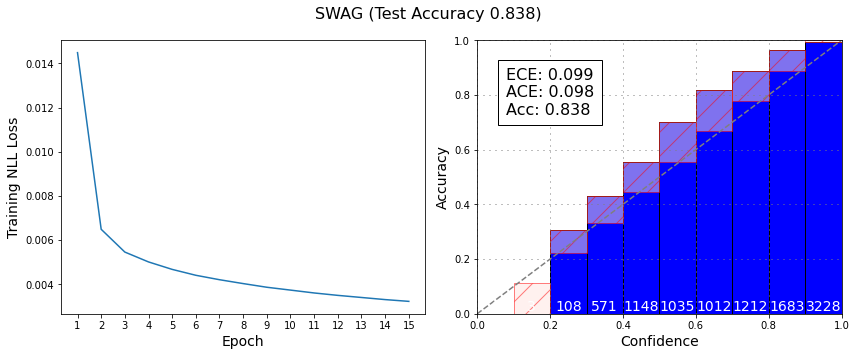

In [13]:
exp.eval_model("SWAG", swag.infer, swag.all_losses(), 100, testloader, device).savefig("figures/fmnist_swag20k_15e.png")

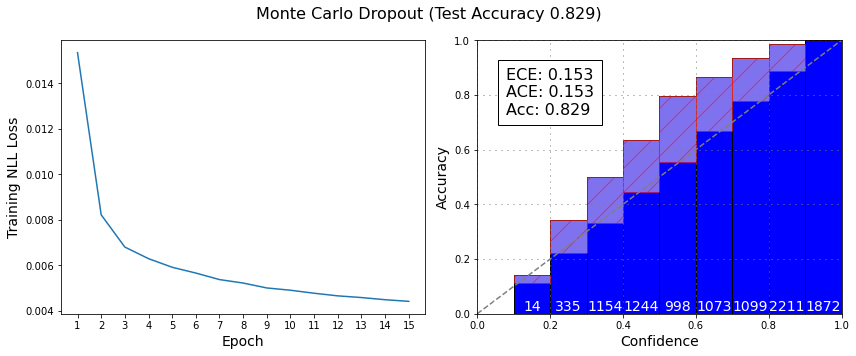

In [14]:
exp.eval_model("Monte Carlo Dropout", mc_dropout.infer, mc_dropout.all_losses(), 100, testloader, device).savefig("figures/fmnist_mcd0.1p_15e.png")

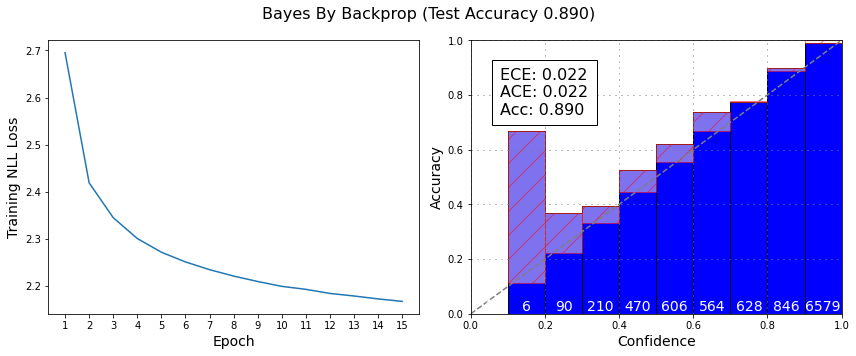

In [15]:
exp.eval_model("Bayes By Backprop", lambda x, s: bbb.infer(x, s), bbb.all_losses(), 100, testloader, device).savefig("figures/fmnist_bbb_15e.png")

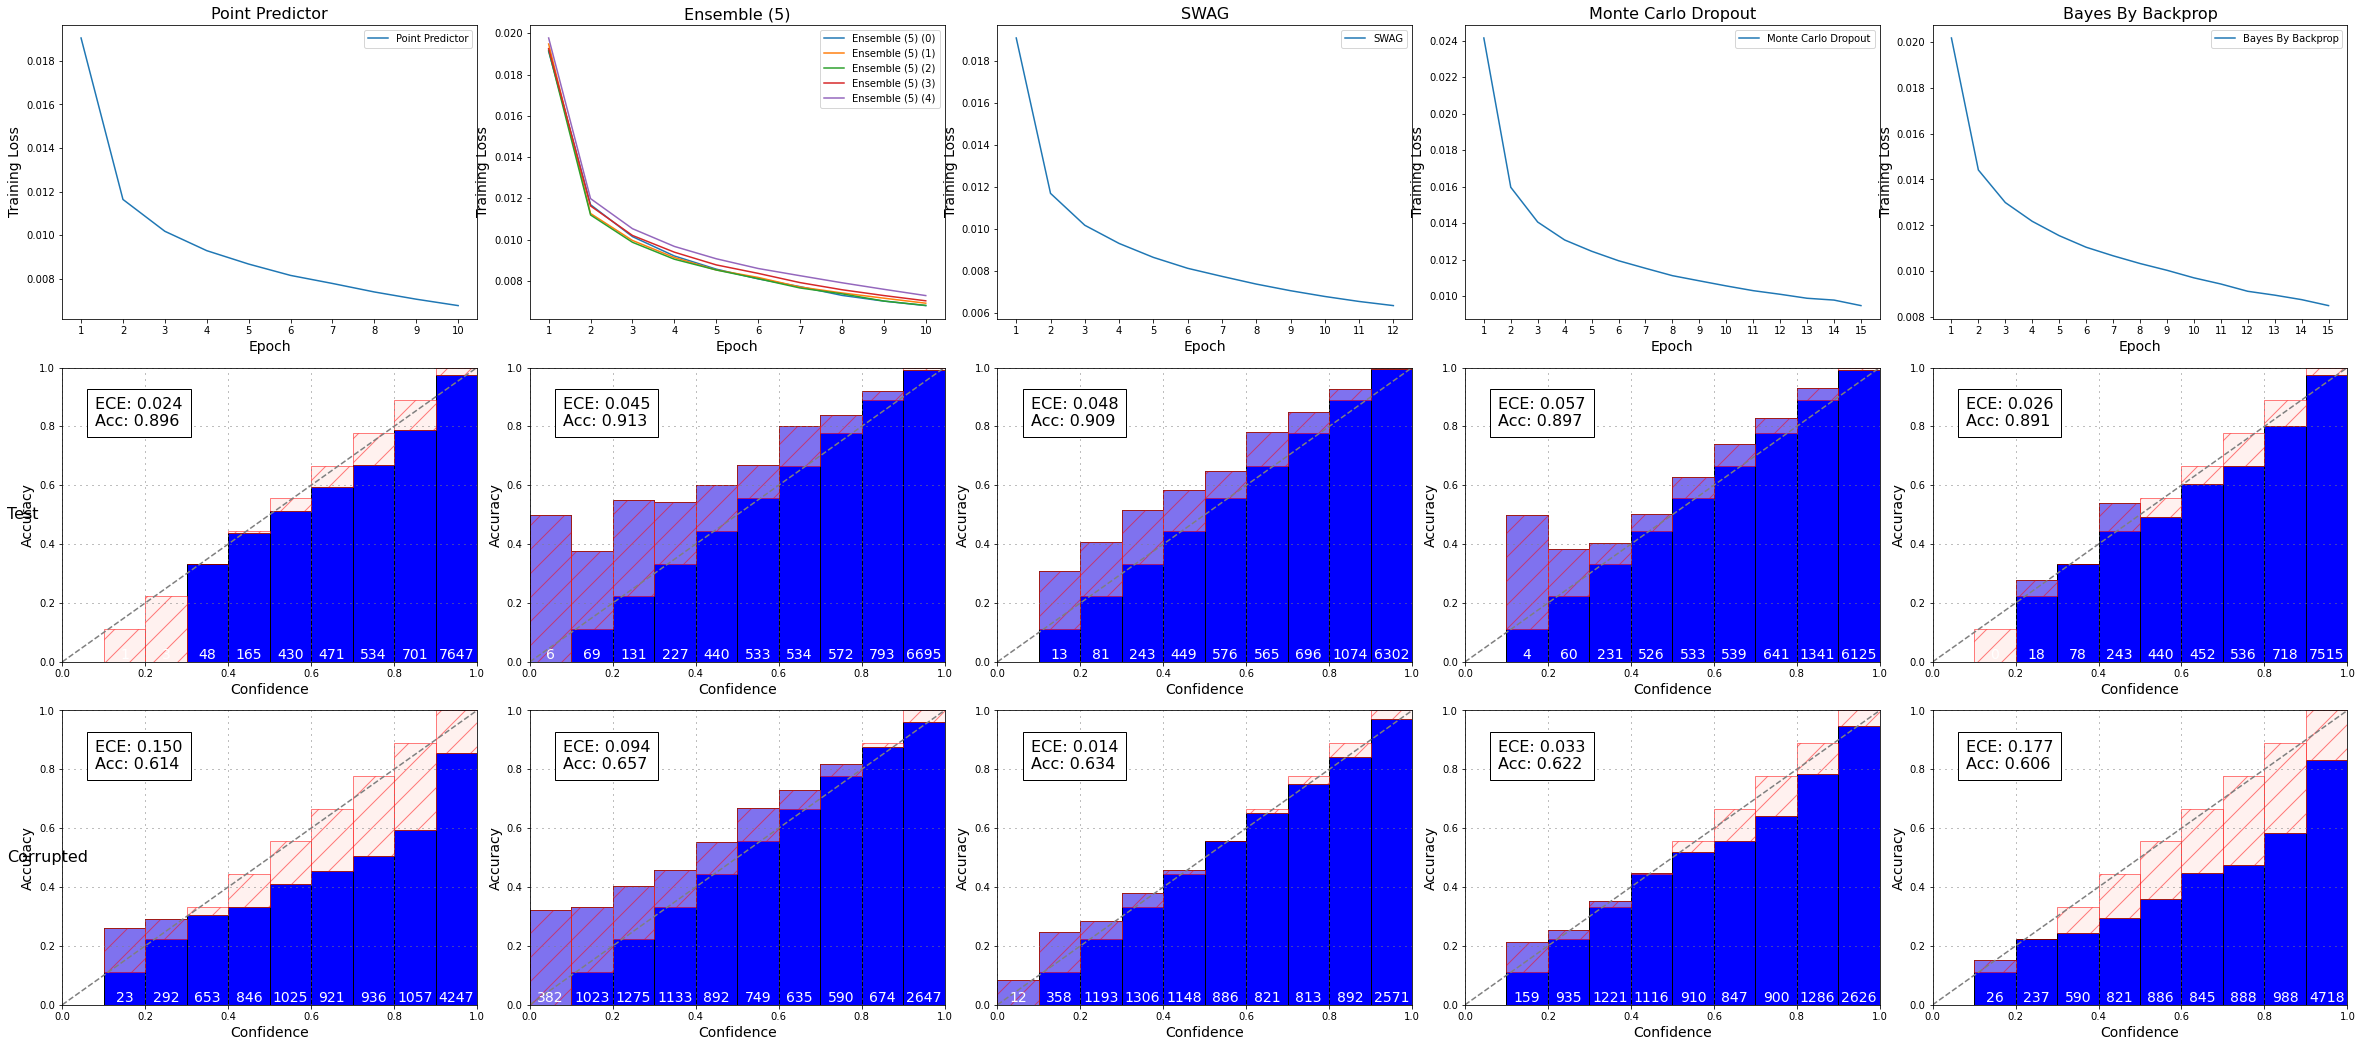

In [44]:
exp.eval_multiple(
    [
        ("Point Predictor", pp.infer, pp.all_losses(), [], 1),
        ("Ensemble (5)", ensemble.infer, ensemble.all_losses(), [], 5),
        ("SWAG", swag.infer, swag.all_losses(), [], 100),
        ("Monte Carlo Dropout", mc_dropout.infer, mc_dropout.all_losses(), [], 100),
        ("Bayes By Backprop", bbb.infer, bbb.all_losses(), [], 100)
    ],
    [
        ("Test", testloader),
        ("Corrupted", corrupted_testloader)
    ],
    device
).savefig("results/Fashion-MNIST/fmnist_all.png")